In [1]:
import openai
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from googlesearch import search
from docx import Document

import re
import requests
import nltk
import spacy

In [2]:
%cd ..

with open('private.txt', 'r') as f:
    content = f.read()
    key = re.findall(r'\'.*?\'', content)[0].strip('\'')
    openai.api_key = key
f.close()

%cd experiment    

h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp
h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp\experiment


# Utility

In [3]:
def parse_date_from_html(html_string):
    "parse date from html. Input html as byte object. The output is a string."
    try:
        regex = b"\d{4}-\d{2}-\d{2}" # b stands for byte like! not a string yet
        date = re.search(regex, html_string)[0]
        date_string = date.decode('utf-8') # turn to string
    except:
        try:
            regex = b"\d{4}\/\d{2}\/\d{2}" # b stands for byte like! not a string yet
            date = re.search(regex, html_string)[0]
            date_string = date.decode('utf-8')#.replace("/", "-") # turn to string
        except:
            date_string = 'no date detected'
    return date_string

def parse_title_from_html(html_string):
    "parse_title_from_html. Input html as byte object. The output is a string."
    try:
        title = re.search(b'<title>(.*?)</title>', html_string).group(1)
        title = title.decode('utf-8')
        title = title.split('.')[0].split('&')[0].split('|')[0].split('-')[0]
    except:
        title = 'no title detected'
    return title

# Define Keywords

In [4]:
# define key words
keywords = ['Finanzielle Hilfe im Alter', 
            'Rentner in Not',
            'Armut Senioren',
            'Altersarmut Frauen',
            'Renten Pay-Gap',
            'Unterstützung Rentner']

# Generate Topic List 

## Generate Topics from Latest Article Headlines Found by Google Search

In [5]:
# Query google keyword by keyword
source_google = []
titles_google = []
publication_dates_google = []

for kw in keywords:
  query = kw
  for url in search(query, num_results=10, lang="de"):
      # get html string
      html_string = requests.get(url).content     
      # get title
      title = parse_title_from_html(html_string)
      # get date
      date = parse_date_from_html(html_string)
      # save results in lists
      source_google.append(url)
      titles_google.append(title)
      publication_dates_google.append(date)

      print(url)  
      print(title)
      print(date)

https://familienportal.de/familienportal/lebenslagen/alter/staatliche-leistungen
Staatliche Leistungen im Alter 
no date detected
https://www.caritas.de/hilfeundberatung/ratgeber/alter/pflege/finanzielle-hilfe-wenn-die-rente-nicht-reicht
Finanzielle Hilfe wenn die Rente nicht reicht
2021-10-04
https://www.kennstdueinen.de/magazin/geldnot-im-alter-welche-finanziellen-hilfen-gibt-es-wenn-die-rente-nicht-reicht/
Geldnot im Alter 
2015-09-04
https://www.seniorenlebenshilfe.de/dienstleistungen-fuer-senioren/grundsicherung-im-alter/
Wichtige Infos zur Grundsicherung im Alter 
2021-07-13
https://www.focus.de/finanzen/altersvorsorge/staatliche-unterstuetzung-viel-mehr-geld-im-alter-sieben-lohnende-zuschuesse-fuer-rentner_id_8970984.html
Viel mehr Geld im Alter: Sechs lohnende Zuschüsse für Rentner 
2018-05-25
https://www.serviceportal-zuhause-im-alter.de/wohnen/laenger-zuhause-wohnen/finanzielle-foerderung.html
Finanzielle Förderung 
no date detected
https://www.einherzfuerrentner.de/fuer-rent

In [6]:
#source_google = []
#titles_google = []
#publication_dates_google = []
len(publication_dates_google)

62

In [7]:
# turn titles and sources into dataframe
df_titles_google = pd.DataFrame({'source': source_google, 'title': titles_google, 'date': publication_dates_google})
df_titles_google.head(10)

,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
5,https://www.serviceportal-zuhause-im-alter.de/...,Finanzielle Förderung,no date detected
6,https://www.einherzfuerrentner.de/fuer-rentner/,Für Rentner,2023-02-02
7,https://www.ihre-vorsorge.de/magazin/lesen/wen...,Wenn das Geld im Alter nicht reicht: Finanziel...,2023-02-27
8,https://www.betanet.de/sozialhilfe-altenhilfe....,Sozialhilfe > Altenhilfe,no date detected
9,https://seniorenhilfe-lichtblick.de/,LichtBlick Seniorenhilfe e,2023-02-15


## Generate Topics Based on ChatGPT

In [8]:
instruction = \
"Nenne zu folgenden Keywords " + '\n' \
'keywords = ' + str(keywords)  + '\n' \
'20 Themenüberschriften.'
print('Instruction: ', instruction)

Instruction:  Nenne zu folgenden Keywords 
keywords = ['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
20 Themenüberschriften.


In [9]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

titles_chatgpt = response['choices'][0].text

# format titles and put into list
titles_chatgpt = [title.strip().replace("\n", "").replace(". ", "") for title in re.split(r'\d+', titles_chatgpt)]

In [10]:
# turn titles and sources into dataframe
date_today = datetime.date.today().strftime("%Y-%m-%d")
df_titles_chatgpt = pd.DataFrame({'source': 'chatgpt', 'title': titles_chatgpt, 'date': date_today})
df_titles_chatgpt.head(10)

,source,title,date
0,chatgpt,,2023-02-27
1,chatgpt,Finanzielle Unterstützung für ältere Menschen ...,2023-02-27
2,chatgpt,Wie Rentner aus der Armut kommen,2023-02-27
3,chatgpt,Seniorenarmut – ein wachsendes Problem,2023-02-27
4,chatgpt,Altersarmut bei Frauen – eine besondere Heraus...,2023-02-27
5,chatgpt,Der Renten-Pay-Gap – Warum die Kluft zwischen ...,2023-02-27
6,chatgpt,Hilfe für Rentner in finanziell schwierigen Ze...,2023-02-27
7,chatgpt,Wie man Senioren vor Armut schützt,2023-02-27
8,chatgpt,Was Altersarmut für Frauen bedeutet und wie si...,2023-02-27
9,chatgpt,Die Folgen des Renten-Pay-Gaps – was die Zahle...,2023-02-27


In [11]:
# concat both title dataframes
df_titles = df_titles_google.append(df_titles_chatgpt)
df_titles

C:\Users\Sebas\AppData\Local\Temp\ipykernel_3132\473715585.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_titles = df_titles_google.append(df_titles_chatgpt)


,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
...,...,...,...
16,chatgpt,Wie man Altersarmut bei Frauen verhindern kann,2023-02-27
17,chatgpt,Der Kampf gegen den Renten-Pay-Gap – ein Forts...,2023-02-27
18,chatgpt,So erhalten Rentner die notwendige Unterstützung,2023-02-27
19,chatgpt,"Warum Armutsbekämpfung unerlässlich ist, um Se...",2023-02-27


## Apply Topic-Keyword Similarity Filter

In [12]:
nlp = spacy.load("de_core_news_lg")

In [13]:
# measure similarity between the titles and the keywords
title_keyword_similarity = []
for title in df_titles['title']:
  sim_score = 0
  for kw in keywords:
    sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability
  # append sum of similarity scores
  title_keyword_similarity.append(np.round(sim_score, 2))

C:\Users\Sebas\AppData\Local\Temp\ipykernel_3132\4193192492.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability


In [14]:
# Add title-keyword similarity scores to df_titles
df_titles['keyword_similarity'] = title_keyword_similarity
df_titles.head()

,source,title,date,keyword_similarity
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected,0.40
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04,0.40
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04,0.33
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13,0.30
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25,0.39


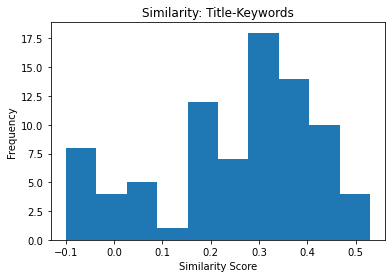

In [15]:
# show title-similarity distribution
plt.hist(df_titles['keyword_similarity'])
plt.title('Similarity: Title-Keywords')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
# filter out similarity score < 0.1
df_titles = df_titles[df_titles['keyword_similarity'] > 0.1]
df_titles = df_titles.sort_values(by='keyword_similarity', ascending=False, ignore_index=True)
df_titles

,source,title,date,keyword_similarity
0,chatgpt,Finanzielle Unterstützung für ältere Menschen ...,2023-02-27,0.53
1,https://www.bpb.de/kurz-knapp/zahlen-und-fakte...,Altersarmut,2020-11-28,0.53
2,chatgpt,Hilfe für Rentner in finanziell schwierigen Ze...,2023-02-27,0.52
3,https://www.viele-schaffen-mehr.de/projekte/hi...,Finanzielle Hilfe für Rentner in Not,no date detected,0.52
4,https://www.wn.de/muenster/immer-mehr-rentner-...,Immer mehr Rentner in Not,2022-10-07,0.46
...,...,...,...,...
61,chatgpt,Der Kampf gegen den Renten-Pay-Gap – ein Forts...,2023-02-27,0.19
62,https://www.fr.de/wirtschaft/altersarmut-fraue...,Altersarmut bei Frauen: „Am Ende kümmert sich ...,2022-07-15,0.19
63,https://www.dza.de/detailansicht/im-arbeitsleb...,Im Arbeitsleben und im Ruhestand: gravierende ...,2022-10-18,0.18
64,https://www.malteser.de/dabei/information-tipp...,Altersarmut in Deutschland: Ein Überblick,no date detected,0.17


## Save Topic Ideation as Word Document

In [19]:
# create a word document 
document = Document()

# add table to document
table = document.add_table(rows=1, cols=4)
table.style = 'Table Grid'

# add table header
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Source'
hdr_cells[1].text = 'Title'
hdr_cells[2].text = 'Date'
hdr_cells[3].text = 'Keyword Similarity'

# add data to table
for i in range(len(df_titles)):
    row_cells = table.add_row().cells
    row_cells[0].text = df_titles.iloc[i]['source']
    row_cells[1].text = df_titles.iloc[i]['title']
    row_cells[2].text = df_titles.iloc[i]['date']
    row_cells[3].text = str(df_titles.iloc[i]['keyword_similarity'])

# save word document
document.save('topic_ideation.docx')

# Advise ChatGPT to Write Article for Given Topic

In [20]:
topic = df_titles['title'][2]
print(topic)

Hilfe für Rentner in finanziell schwierigen Zeiten


In [21]:
instruction = "\n" + \
"Schreibe einen Artikel von 250 Wörtern zum Thema: \n" + \
topic + '. \n' + \
"Der Artikel soll die Schlüsselbegriffe " + '\n' + \
str(keywords) + '\n' + \
"enthalten." + '\n' + \
"Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein." + '\n' + \
"Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten."

print('Instruction: ', instruction)

Instruction:  
Schreibe einen Artikel von 250 Wörtern zum Thema: 
Hilfe für Rentner in finanziell schwierigen Zeiten. 
Der Artikel soll die Schlüsselbegriffe 
['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
enthalten.
Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein.
Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten.


In [23]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

text_seo = response['choices'][0].text

In [24]:
print(text_seo)



Finanzielle Hilfe im Alter: Unterstützung für Rentner in Not
Immer mehr Rentner geraten aufgrund von Armut ins Hintertreffen. Um dieser Entwicklung entgegenzuwirken, bieten verschiedene Organisationen und Initiativen finanzielle Hilfe für Senioren an. 

Armut Senioren: Altersarmut bei Frauen
Laut einer Studie des Deutschen Instituts für Wirtschaftsforschung (DIW) sind vor allem ältere Frauen von Altersarmut betroffen. Dies liegt daran, dass sie in der Regel niedrigere Renten erhalten als Männer. 

Renten Pay-Gap: Ungerechtfertigte Benachteiligung?
Der sogenannte "Renten-Pay-Gap" ist ein großes Problem in Deutschland und sollte dringend angegangen werden. Denn es ist ungerecht, dass Frauen trotz gleicher Arbeit schlechter bezahlt werden und somit auch geringere Renten erhalten als Männer. 

Unterstützung Rentner: Finanzielle Hilfe für Senioren
Um die finanzielle Situation von Rentnern zu verbessern, gibt es verschiedene Programme und Initiativen, die ihnen helfen können. Zum Beispiel 

## Save SEO Text as Word Document

In [25]:
# Create a new document object.
document = Document()

# Create a new paragraph object.
paragraph = document.add_paragraph()

# Write the string to the paragraph object.
paragraph.add_run(text_seo)

# Save the document.
document.save('seo_text.docx')

# ToDo

- Include Keywords into article generation -> ok
- Add column with publication date! -> ok
- Save Topic List and hand over to Alexa -> warte auf Feedback
- correct topic titles
- code review: make functions
- develop streamlit app